# Lab1 

## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

## 1. init_params(nx, nh, ny) 
Write the function init_params(nx, nh, ny) 
that initialize the weights of an MLP based
on nx, nh, and ny that presents the number of neurons in each layer : input (x),
hidden (h), and output (y). All weights must be initialized following the normal
distribution with an average of 0 and a standard deviation of 0.3

In [2]:
def init_params(nx, nh, ny):
    np.random.seed(42)
    W1 = np.random.normal(0, 0.3, (nx, nh)) 
    b1 = np.random.normal(0, 0.3, (1, nh))
    W2 = np.random.normal(0, 0.3, (nh, ny))
    b2 = np.random.normal(0, 0.3, (1, ny))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

In [3]:
print(init_params(1,2,1))

{'W1': array([[ 0.14901425, -0.04147929]]), 'b1': array([[0.19430656, 0.45690896]]), 'W2': array([[-0.07024601],
       [-0.07024109]]), 'b2': array([[0.47376384]])}


## 2. Forward propagation

In [4]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#### The equations:
\
\begin{align}
    Z_1 &= W_1 X + b_1 \\
    A_1 &= \tanh(Z_1) \\
    Z_2 &= W_2 A_1 + b_2 \\
    A_2 &= softamx(Z_2)
\end{align}

In [5]:
#batch size = number of samples and nx = number of features per sample
def forward(params, X):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    Z1 = np.dot(X, W1) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(A1, W2) + b2
    Yhat = softmax(Z2) # this will gives for each sample the proba of its classes 
    return Yhat, {'Z1': Z1, 'A1': A1, 'Z2': Z2}

## 3. Loss and accuracy calculation

In [6]:
def loss_accuracy(Y_hat, Y):
    m = Y.shape[0]
    epsilon = 1e-10  #pour eviter log(0)
    loss = -np.sum(Y * np.log(Y_hat + epsilon)) / m  #cross entropy function
    predictions = np.argmax(Y_hat, axis=1)  #find the max proba in each row to be the selected value
    labels = np.argmax(Y, axis=1)
    accuracy = np.mean(predictions == labels)  #if pred = true => 1 then we calc the mean
    return loss, accuracy

## 4. Backpropagation

### The proof of DW2:
- First we have the cross-entropy loss is: \begin{equation}
    J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} Y_{ik} \log(A_{2ik})
\end{equation}
where $K$ is the number of classes.

- DW2: Using the chain rule
$$
\frac{\partial J}{\partial W_2^{(k)}} = \frac{\partial J}{\partial Z_2^{(k)}} \cdot \frac{\partial Z_2^{(k)}}{\partial W_2^{(k)}}
$$
--> 1.We derive from the cross-entropy loss: $$
 \frac{\partial J}{\partial A_2^{(k)}} = \frac{1}{m} \cdot -\frac{Y_k}{A_2^{(k)}}    ......(1)
$$ 
--> 2.

   we have $$
A_2 = \text{softmax}(Z_2) = \frac{e^{Z_2}}{\sum_{j=1}^C e^{Z_2^{(j)}}}
$$ After derivation we get:
    - For diagonal elements:
                    $$
                        \frac{\partial A_2}{\partial Z_2} = A_2 (1 - A_2)   ....(2)
                    $$
  - For off-diagonal elements:
                    $$
\frac{\partial A_2}{\partial Z_2} = -A_2 A_2  ....(3)
$$
  - And by (1),(2) and (3)we can say:
    $$
\frac{\partial J}{\partial Z_2} = \sum_{j=1}^C \frac{\partial J}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2}
$$
$$
\frac{\partial J}{\partial Z_2} = -Y + A_2 .......(A) $$
    -->  3.And:
        $$
Z_2 = W_2 A_1 + b_2  \Rightarrow \frac{\partial Z_2}{\partial W_2} = A_1^T  .....(B)
$$
- From (A) and (B) we conclude:
$$
\frac{\partial J}{\partial W_2^{(k)}} = dW_2 = \frac{1}{m} \cdot  (A_2 - Y) \cdot A_1^T = \frac{1}{m} \cdot dZ_2 \cdot A_1^T
$$

### The proof of Db2:
$$
\frac{\partial J}{\partial b_2} = \frac{\partial J}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial b_2}
$$

$$ Z_2 = W_2 A_1 + b_2  \Rightarrow \frac{\partial Z_2}{\partial b_2} = 1 $$

- So:
$$
\frac{\partial J}{\partial b_2} = \frac{\partial J}{\partial Z_2}=dZ_2
$$

### The proof of DW1:

$$
\frac{\partial J}{\partial W_1} = \frac{\partial J}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1}
$$

- We get the first part from (A)

- And the second part from:
$$
Z_2 = W_2 A_1 + b_2 \Rightarrow \frac{\partial Z_2}{\partial A_1} = W_2 ......(C)
$$

- 3rd part is:

$$
A_1= \tanh(Z_1) \Rightarrow \frac{\partial A_1}{\partial Z_1} = 1 - \tanh(Z_1)^2 = 1 - A_1^2
$$

- So :
$$
\frac{\partial A_1}{\partial Z_1}=dZ_1 = dA_1 (1 - A_1) ......(D)
$$

- 4th part:
$$
dW_1 = \frac{\partial J}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1}
$$
$$
Z_1 = X \cdot W_1 + b_1 \Rightarrow  \frac{\partial Z_1}{\partial W_1} = X
$$
- So :
$$
\frac{\partial Z_1}{\partial W_1} = dW_1 =   X^T  ........(E)
$$
- From (A) , (C) ,(D) and (E) we conclude:
$$
dW_1 = dZ_1 \cdot X^T
$$

### The proof of Db1:
$$
\frac{\partial J}{\partial b_1} = \frac{\partial J}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial b_1}
$$

$$ Z_1 = X W_1 + b_1  \Rightarrow \frac{\partial Z_1}{\partial b_1} = 1 $$

$$
\frac{\partial J}{\partial b_1} = dZ_1
$$

- Averaging over m examples so we get:
$$
db_1 = \sum_{i=1}^m dZ_1^{(i)}
$$

In [7]:
def backward(X, params, outputs, Y):
    m = Y.shape[0]
    W2 = params['W2']
    A1 = outputs['A1']
    Z2 = outputs['Z2'] # Z2 =A1* W2 + b2
    Y_hat = softmax(Z2)
    
    dZ2 = (Y_hat - Y) / m # dJ/dZ2 is simplified to (Y_hat - Y).
    dW2 = np.dot(A1.T, dZ2) 
    db2 = np.sum(dZ2, axis=0, keepdims=True) 
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (1 - np.square(A1))
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    
    return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

## 5. SGD 

In [8]:
def sgd(params, grads, eta):
    for key in params:
        params[key] -= eta * grads[key]
    return params

## 6. Training and visualization

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
original_y_train = y_train.copy()  

In [10]:
X_train = X_train.reshape(-1, 28*28) / 255.0 #we reshape the images from 28x28 to 784 features and normalize it by dividing by 255
X_test = X_test.reshape(-1, 28*28) / 255.0

y_train = to_categorical(y_train, 10) # convert it by one hot encoding
y_test = to_categorical(y_test, 10)

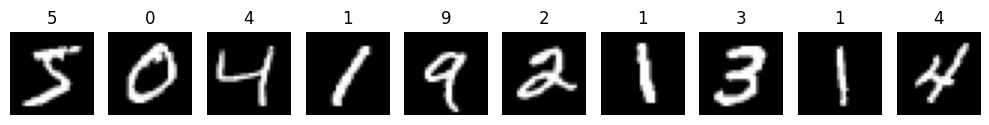

In [11]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(original_y_train[i])
plt.tight_layout()
plt.show()

In [12]:
nx, nh, ny = 784, 128, 10
eta, batch_size, epochs = 0.1, 128, 50
params = init_params(nx, nh, ny)

train_losses, train_accs = [], []
test_losses, test_accs = [], []

In [13]:
params = init_params(nx, nh, ny)

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train[perm], y_train[perm]

    for i in range(0, X_train.shape[1], batch_size):
        X_batch, y_batch = X_train[i:i + batch_size], y_train[i:i + batch_size]

        Yhat, outputs = forward(params, X_batch)

        grads = backward(X_batch, params, outputs, y_batch)

        sgd(params, grads, eta)

        loss, accuracy = loss_accuracy(Yhat, y_batch)
        loss_history.append(loss)
        accuracy_history.append(accuracy)

    if accuracy_history[-1] > 99:
        break


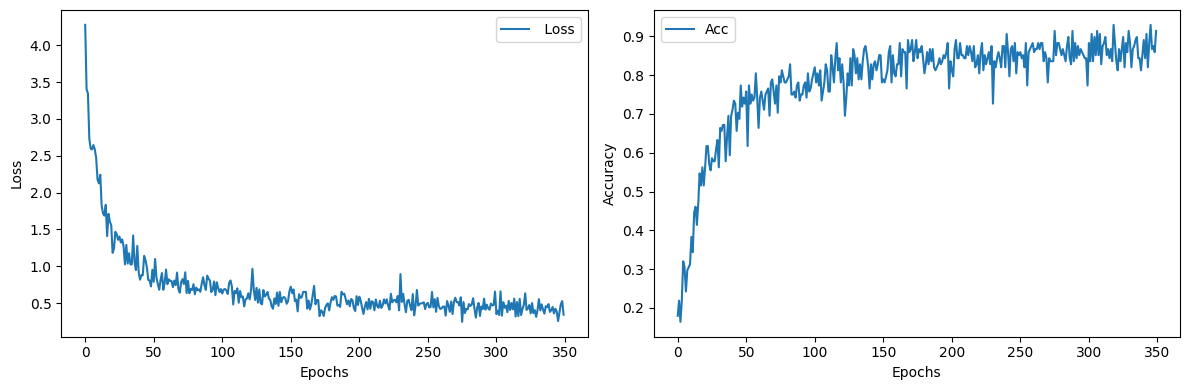

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label=' Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()